## Imports

In [1]:
import os
import sys
import scipy
import datetime

In [2]:
sys.path.append(os.path.join(os.pardir, 'src'))

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
from tqdm.notebook import tqdm
from collections import defaultdict

In [6]:
from CBO.distributions import Normal
from CBO.functions import rastrigin, rastrigin_c, square
from CBO.minimize import minimize
from CBO.visualizations import visualize_trajectory_convergence
from CBO.train import train, NeuralNetworkObjectiveFunction, TensorboardLogging, compute_model_dimensionality

## Data preparation

In [7]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def load_mnist_data():
    (X_train, y_train),(X_test, y_test) = mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_mnist_data()

## Model training

In [9]:
def build_default_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])

In [10]:
def build_small_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(10),
    ])

In [40]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
#                                                      reduction=tf.keras.losses.Reduction.SUM)
# loss_fn = lambda y, y_pred: loss(y, y_pred) / y.shape[0]

In [34]:
! rm -rf logs/fit

In [13]:
def conduct_tf_training(model, X_train, X_test, y_train, y_test, with_tensorboard=False,
                        model_description='', epoches=10):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    if with_tensorboard:
        log_dir = 'logs/fit/' + model_description
        if model_description is '':
            log_dir += datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test),
                  callbacks=[tensorboard_callback])
    else:
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test))
    
    return model

In [14]:
tensorboard_logging = TensorboardLogging('cbo_small', 'logs/fit')

In [42]:
cbo_small_model, trajectory = train(build_small_model(), loss, X_train, y_train, n_particles=10, 
                                    time_horizon=2,
                                    optimizer_config = {'alpha': 1, 'sigma': 0.4**0.5, 'dt': 0.1}, 
                                    initial_distribution=Normal(0, 1),
                                    return_trajectory=True, verbose=True, particles_batches=1, 
                                    dataset_batches=60, X_val=X_test, y_val=y_test, 
                                    tensorboard_logging=tensorboard_logging, cooling=True)

KeyboardInterrupt: 

In [16]:
adam_small_model = conduct_tf_training(build_small_model(),
                                       X_train, X_test, y_train, y_test,
                                       with_tensorboard=True,
                                       model_description='adam_small', epoches=20)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5356 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.3096 - val_sparse_categorical_accuracy: 0.9097
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3224 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.2885 - val_sparse_categorical_accuracy: 0.9157
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2992 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.2652 - val_sparse_categorical_accuracy: 0.9224
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.9165 - val_loss: 0.2682 - val_sparse_categorical_accuracy: 0.9243
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2784 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.2595 - val_sparse_categorical_accuracy: 0.9260
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2745 - spars

## Results analysis

In [22]:
def calculate_cbo_weights(particles, objective, alpha=50):
    objective_values = np.array([objective(particle) for particle in particles])
    weights = np.exp(-alpha * (objective_values - objective_values.min())).reshape(-1, 1)
    return weights / weights.sum()

In [16]:
nn_loss = NeuralNetworkObjectiveFunction(build_small_model(), loss, X_train, y_train)

In [17]:
def update_model_parameters(model, parameters):
    current_position = 0
    for weight in model.trainable_weights:
        next_position = current_position + tf.size(weight)
        weight.assign(tf.reshape(parameters[current_position:next_position], weight.shape))
        current_position = next_position
    return model

In [19]:
def plot_particle_loss(trajectory, particle_ind, nn_loss):
    timestamps = list(sorted(trajectory.keys()))
    losses = []
    for ts in timestamps:
        losses.append(nn_loss(trajectory[ts]['particles'][particle_ind]))
    plt.clf()
    plt.plot(timestamps, losses)
    plt.show()

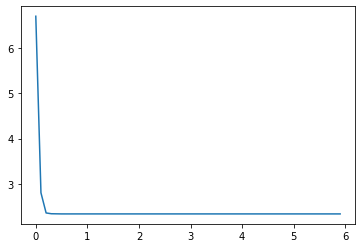

In [43]:
plot_particle_loss(trajectory, 0, nn_loss)

In [23]:
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [67]:
weights.max()

0.010008718

In [64]:
weights = calculate_cbo_weights(trajectory[1.0999999999999999]['particles'], nn_loss)

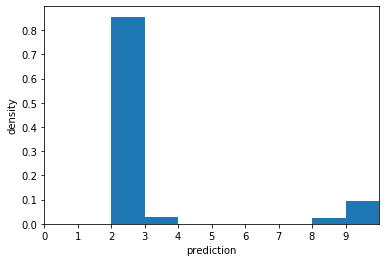

Train accuracy: 0.1070791631937027


In [63]:
best_particle_ind = np.equal(weights.max(), weights).nonzero()[0][0]
best_particle = trajectory[1.0999999999999999]['particles'][best_particle_ind]
best_model = update_model_parameters(build_small_model(), trajectory[1.0999999999999999]['particles'][best_particle_ind])
plot_model_predictive_distribution(build_small_model(), trajectory[1.0999999999999999]['particles'][best_particle_ind], X_train)
accuracy.update_state(y_train, best_model.predict(X_train))
print(f'Train accuracy: {accuracy.result().numpy()}')

In [56]:
trajectory.keys()

dict_keys([0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.2, 1.3, 1.4000000000000001, 1.5000000000000002, 1.6000000000000003, 1.7000000000000004, 1.8000000000000005, 1.9000000000000006, 2.0000000000000004, 2.1000000000000005, 2.2000000000000006, 2.3000000000000007, 2.400000000000001, 2.500000000000001, 2.600000000000001, 2.700000000000001, 2.800000000000001, 2.9000000000000012, 3.0000000000000013, 3.1000000000000014, 3.2000000000000015, 3.3000000000000016, 3.4000000000000017, 3.5000000000000018, 3.600000000000002, 3.700000000000002, 3.800000000000002, 3.900000000000002, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000001, 4.4, 4.5, 4.6, 4.699999999999999, 4.799999999999999, 4.899999999999999, 4.999999999999998, 5.099999999999998, 5.1999999999999975, 5.299999999999997, 5.399999999999997, 5.4999999999999964, 5.599999999999996, 5.699999999999996, 5.799999999999995, 5.89999999999

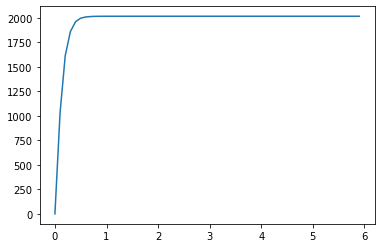

In [55]:
plt.clf()
timestamps = list(sorted(trajectory.keys()))
distances = [tf.reduce_sum((best_particle - trajectory[ts]['particles'][best_particle_ind]) ** 2)
             for ts in timestamps]
plt.plot(timestamps, distances)

In [68]:
consensus_postions = [trajectory[ts]['consensus'] for ts in sorted(trajectory.keys())]

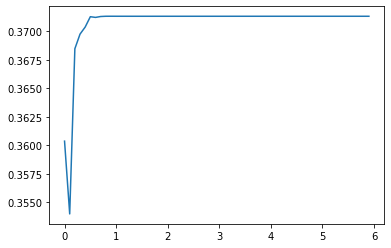

In [77]:
plt.clf()
plt.plot(timestamps, [consensus_postions[i][0][1] for i in range(len(consensus_postions))])
plt.show()

In [19]:
all_weights = np.concatenate([tf.reshape(w, -1).numpy() for w in adam_small_model.trainable_weights])

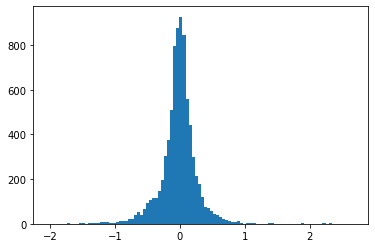

In [20]:
plt.clf()
plt.hist(all_weights, bins=100)
plt.show()

In [40]:
def get_model_predictions(model, parameters, X):
    model = update_model_parameters(model, tf.reshape(parameters, -1))
    predictions = model(X).numpy()
    return np.argmax(predictions, axis=1)

def get_predictions_distribution(values):
    _, counts = np.unique(values, return_counts=True)
    return 1. * counts / counts.sum()

def plot_model_predictive_distribution(model, parameters, X, title=''):
    plt.clf()
    plt.xticks(range(10))
    plt.xlim((0, 10))
    plt.title(title)
    predictions, counts = np.unique(get_model_predictions(model, parameters, X),
                                    return_counts=True)
    plt.bar(x=predictions + 0.5, height=1.*counts/counts.sum(), width=1)
    plt.xlabel('prediction')
    plt.ylabel('density')
    plt.show()

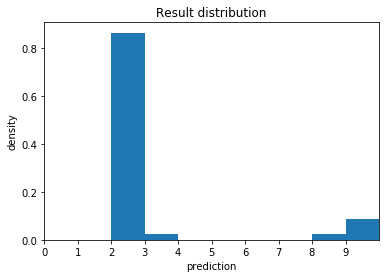

In [41]:
last_timestamp = list(sorted(trajectory.keys()))[-1]
plot_model_predictive_distribution(build_small_model(),
                                   trajectory[last_timestamp]['consensus'],
                                   X_test, 'Result distribution')

In [42]:
def plot_particles_entropy(model, trajectoty, X, n_particles=10, logarithmic=False):
    overall_particles = len(trajectory[0]['particles'])
    particles = list(sorted(np.random.choice(overall_particles, n_particles, replace=False)))
    entropy = defaultdict(lambda: [])
    timestamps = list(sorted(trajectoty.keys()))
    for timestamp in tqdm(timestamps):
        for particle in particles:
            predictions = get_model_predictions(model, trajectoty[timestamp]['particles'][particle], X)
            entropy[particle].append(scipy.stats.entropy(get_predictions_distribution(predictions)))
    plt.clf()
    plt.rcParams['figure.figsize'] = (15, 15)
    for particle, particle_entropy in entropy.items():
        plt.plot(timestamps, np.log(particle_entropy) if logarithmic else particle_entropy, 
                 label=f'particle {particle}')
    plt.xlabel('Timestamp')
    plt.ylabel('Predictive distribution entropy')
    plt.legend()
    plt.show()

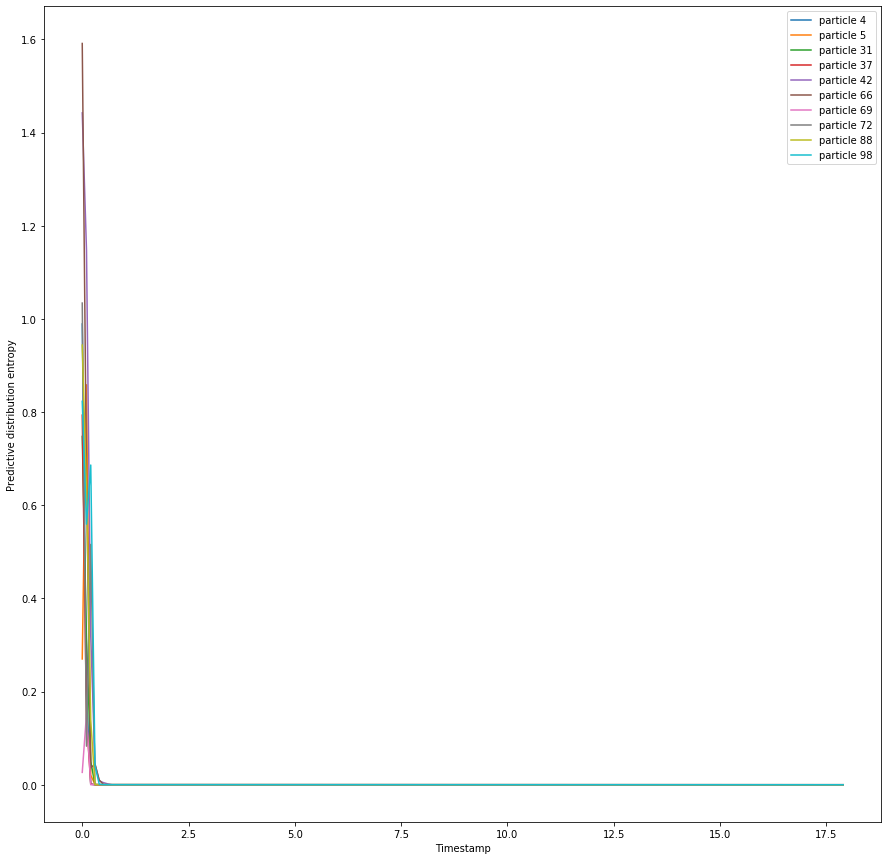

In [142]:
plot_particles_entropy(build_small_model(), trajectory, X_train)

In [43]:
def visualize_particle_path_1d(trajectory, particle_ind, projection_dimenssion):
    timestamps = list(sorted(list(trajectory.keys())))
    particle_positions = [trajectory[ts]['particles'][particle_ind][projection_dimenssion]
                          for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, particle_positions)
    plt.xlabel('Timestamp')
    plt.ylabel('Particle position')
    plt.show()
    
def visalize_particles_shift(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    shifts = []
    for ind, ts in enumerate(timestamps[:-1]):
        shifts.append(tf.norm(trajectory[ts]['particles'] - trajectory[timestamps[ind + 1]]['particles'],
                              ord='euclidean'))
    plt.clf()
    plt.plot(timestamps[1:], shifts)
    plt.xlabel('Timestamp')
    plt.ylabel('Shift')
    plt.show()
    
def visalize_particles_std(trajectory, logarithmic=False):
    timestamps = list(sorted(list(trajectory.keys())))
    stds = []
    for ts in timestamps:
        stds.append(tf.math.reduce_std(trajectory[ts]['particles']))
    if logarithmic:
        stds = np.log(stds)
    plt.clf()
    plt.plot(timestamps, stds)
    plt.xlabel('Timestamp')
    plt.ylabel('Std')
    plt.show()

# contrains accuracies from different batches!
def visualize_cbo_accuracy(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    accuracies = [trajectory[ts]['accuracy'] for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, accuracies)
    plt.xlabel('Timestamp')
    plt.ylabel('Accuracy')
    plt.show()

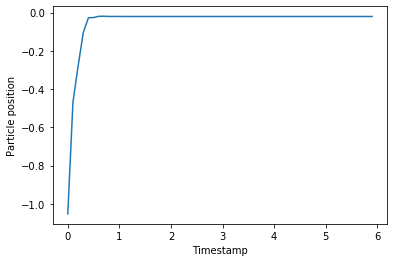

In [61]:
visualize_particle_path_1d(trajectory, best_particle_ind, 4)

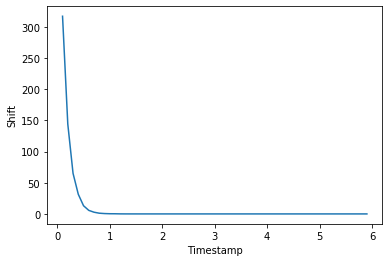

In [32]:
visalize_particles_shift(trajectory)

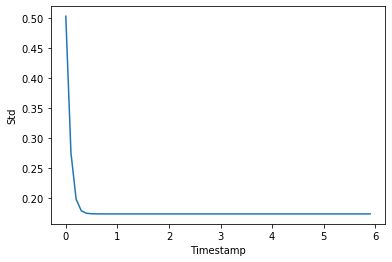

In [20]:
visalize_particles_std(trajectory)

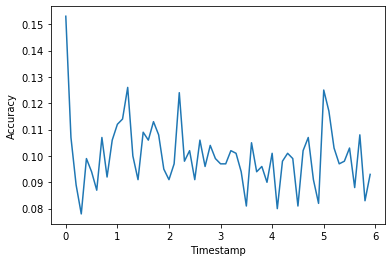

In [21]:
visualize_cbo_accuracy(trajectory)

## Random initialization leads to unbalanced predictions of the initial model!

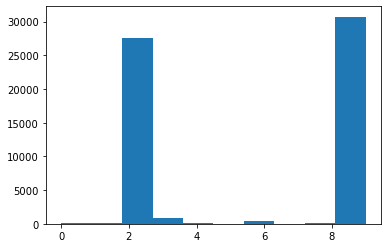

In [51]:
model = build_small_model()
initial_weights = tf.Variable(Normal(0, 1).sample(compute_model_dimensionality(model)))
model = update_model_parameters(model, initial_weights)
y_pred = np.argmax(tf.nn.softmax(model(X_train)), axis=1)
plt.hist(y_pred)
plt.show()